<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Langgraph/agentic_rag/sql_agent_with_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SQL Agent with Langgraph

### Introduction and Goal of the Notebook

#### **Introduction:**

This notebook demonstrates the use of a **Langraph SQL Agent Workflow**, as visualized in the provided flow diagram, to create an intelligent, automated system for interacting with an SQLite database. By leveraging **Langraph**, **LangChain**, and Large Language Models (LLMs), the notebook sets up a pipeline where users can ask natural language questions and receive precise SQL-generated insights from the database.

The flow diagram illustrates a structured, tool-driven workflow consisting of:
1. **Starting the process**: The workflow begins by listing tables in the database and retrieving their schemas.
2. **Query Generation**: User input in natural language is converted into SQL queries, which are validated and refined if necessary.
3. **Execution and Error Handling**: Queries are executed to extract data, while robust mechanisms are in place to correct and reattempt invalid queries.
4. **Output Generation**: The final results are provided back to the user in an understandable format.

This workflow ensures a seamless and user-friendly interaction with the database, eliminating the need for manual SQL knowledge.

#### **Goal:**

The goal of this notebook is to build a fully-functional, AI-driven system that:
- **Simplifies Data Interaction**: Converts natural language questions into accurate SQL queries.
- **Ensures Query Integrity**: Validates, corrects, and retries queries when errors occur.
- **Streamlines Data Retrieval**: Automates schema understanding, query execution, and results generation.

By implementing the Langraph workflow, this notebook empowers users—regardless of technical expertise—to interact with databases in a conversational manner. This approach enhances productivity, accessibility, and data-driven decision-making in both technical and non-technical environments.

---

In [80]:
# Importing sqlite3 module to interact with SQLite databases
import sqlite3

In [2]:
# Establishing a connection to the SQLite database named "mydb.db"
connection = sqlite3.connect("mydb.db")

In [3]:
# Checking the connection object
connection

In [4]:
# SQL query to create a table for storing employee details if it does not already exist
table_creation_query="""
CREATE TABLE IF NOT EXISTS employees (
    emp_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    hire_date TEXT NOT NULL,
    salary REAL NOT NULL
);
"""

In [5]:
# SQL query to create a table for storing customer details if it does not already exist
table_creation_query2="""
CREATE TABLE IF NOT EXISTS customers (
    customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    phone TEXT
);
"""

In [6]:
# SQL query to create a table for storing order details if it does not already exist
table_creation_query3="""
CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INTEGER NOT NULL,
    order_date TEXT NOT NULL,
    amount REAL NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES customers (customer_id)
);

"""

In [7]:
# Creating a cursor object to execute SQL commands
cursor=connection.cursor()

In [8]:
# Executing the SQL query to create the employees,customers and orders table
cursor.execute(table_creation_query)
cursor.execute(table_creation_query2)
cursor.execute(table_creation_query3)

In [9]:
# SQL query to insert data into the employees table
insert_query = """
INSERT INTO employees (emp_id, first_name, last_name, email, hire_date, salary)
VALUES (?, ?, ?, ?, ?, ?);
"""
# SQL query to insert data into the customers table
insert_query_customers = """
INSERT INTO customers (customer_id, first_name, last_name, email, phone)
VALUES (?, ?, ?, ?, ?);
"""
# SQL query to insert data into the orders table
insert_query_orders = """
INSERT INTO orders (order_id, customer_id, order_date, amount)
VALUES (?, ?, ?, ?);
"""

In [11]:
# Sample data for employees table
employee_data = [
    (1, "Rizwan", "Nazir", "rizwan.nazir@abc.com", "2023-06-01", 50000.00),
    (2, "Zia", "Khan", "zia.k@gmail.com", "2022-04-15", 60000.00),
    (3, "Alice", "Johnson", "alice.johnson@jpg.com", "2021-09-30", 55000.00),
    (4, "Bob", "Brown", "bob.brown@uio.com", "2020-01-20", 45000.00),
    ]

# Sample data for customers table
customers_data = [
    (1, "John", "Doe", "john.doe@example.com", "1234567890"),
    (2, "Jane", "Smith", "jane.smith@example.com", "9876543210"),
    (3, "Emily", "Davis", "emily.davis@example.com", "4567891230"),
    (4, "Michael", "Brown", "michael.brown@example.com", "7894561230"),
]

# Sample data for orders table
orders_data = [
    (1, 1, "2023-12-01", 250.75),
    (2, 2, "2023-11-20", 150.50),
    (3, 3, "2023-11-25", 300.00),
    (4, 4, "2023-12-02", 450.00),
]

In [12]:
# Inserting employee data into the employees, customers and orders table
cursor.executemany(insert_query,employee_data)
cursor.executemany(insert_query_customers,customers_data)
cursor.executemany(insert_query_orders,orders_data)

In [13]:
# Committing the changes to the database
connection.commit()

In [14]:
# Querying all data from the orders table
cursor.execute("select * from orders;")

In [15]:
# Fetching and printing all rows from the orders table
for row in cursor.fetchall():
    print(row)

(1, 1, '2023-12-01', 250.75)
(2, 2, '2023-11-20', 150.5)
(3, 3, '2023-11-25', 300.0)
(4, 4, '2023-12-02', 450.0)


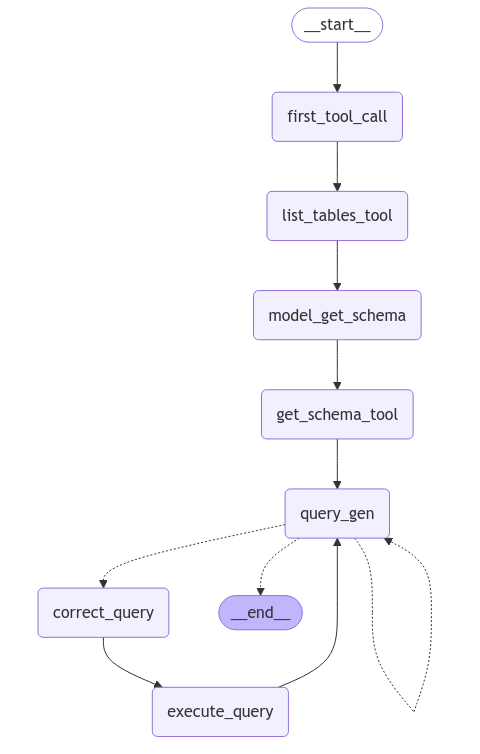

In [50]:
%pip install -qU langchain_community langchain_groq langchain_core langgraph

In [19]:
# Importing SQLDatabase from langchain_community to manage the SQLite database
from langchain_community.utilities import SQLDatabase

In [20]:
# Initializing a SQLDatabase object using the existing SQLite database
db=SQLDatabase.from_uri("sqlite:///mydb.db")

In [21]:
db

In [22]:
# Displaying the database dialect (e.g., SQLite)
db.dialect

'sqlite'

In [23]:
# Fetching usable table names from the database
db.get_usable_table_names()

['customers', 'employees', 'orders']

In [28]:
# Importing modules for accessing environment variables
import os
from google.colab import userdata
os.environ["GROQ_API_KEY"]=userdata.get("GROQ_API_KEY")

# Importing ChatGroq for using a specific language model
from langchain_groq import ChatGroq
# Initializing the LLM with a specific model
llm=ChatGroq(model="llama-3.3-70b-versatile")

In [29]:
# Testing the LLM with a sample prompt
llm.invoke("hello how are you?")

AIMessage(content="Hello. I'm doing well, thanks for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have. How about you? How's your day going so far?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 40, 'total_tokens': 101, 'completion_time': 0.221818182, 'prompt_time': 0.007515647, 'queue_time': 0.020353091, 'total_time': 0.229333829}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'stop', 'logprobs': None}, id='run-dc627503-6744-4101-b628-b495f208b147-0', usage_metadata={'input_tokens': 40, 'output_tokens': 61, 'total_tokens': 101})

In [30]:
# Importing SQLDatabaseToolkit for creating tools to interact with the database
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [31]:
# Initializing the toolkit with the database and the LLM
toolkit=SQLDatabaseToolkit(db=db, llm=llm)

In [32]:
# Fetching tools from the toolkit
tools=toolkit.get_tools()

In [33]:
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f966beb1f00>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f966beb1f00>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f966beb1f00>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [34]:
# Displaying all the tools
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [35]:
# Fetching a specific tool for listing tables in the database
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)

In [36]:
list_tables_tool

ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f966beb1f00>)

In [37]:
# Fetching a specific tool for getting schema information
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)

In [38]:
get_schema_tool

InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f966beb1f00>)

In [39]:
# Invoking the list tables tool
list_tables_tool.invoke("")

'customers, employees, orders'

In [42]:
# Invoking the schema tool to display the schema of the employees table
print(get_schema_tool.invoke("employees"))


CREATE TABLE employees (
	emp_id INTEGER, 
	first_name TEXT NOT NULL, 
	last_name TEXT NOT NULL, 
	email TEXT NOT NULL, 
	hire_date TEXT NOT NULL, 
	salary REAL NOT NULL, 
	PRIMARY KEY (emp_id), 
	UNIQUE (email)
)

/*
3 rows from employees table:
emp_id	first_name	last_name	email	hire_date	salary
1	Rizwan	Nazir	rizwan.nazir@abc.com	2023-06-01	50000.0
2	Zia	Khan	zia.k@gmail.com	2022-04-15	60000.0
3	Alice	Johnson	alice.johnson@jpg.com	2021-09-30	55000.0
*/


The method `run_no_throw()` suggests that it executes a query (likely against a database) and handles exceptions internally without throwing them to the caller. The goal is typically to ensure the program continues running smoothly even if the query fails.

**Key Features of `run_no_throw()`**
1. **Execute a Query**: Runs the SQL query passed as an argument.
2. **Error Handling**: Catches and suppresses exceptions, such as SQL syntax errors or connection issues, instead of letting them propagate.
3. **Returns a Result**: Often, it either:
- Returns the query result if successful.
- Returns a fallback value (like None or an empty dataset) in case of failure.

**Why Use `run_no_throw()`?**
- **Resilience**: Ensures the application doesn't crash due to unexpected database errors.
- **Simplified Code**: Avoids the need for explicit try...except blocks around each database query.
- **Controlled Behavior**: Offers predictable behavior in scenarios where the query might fail (e.g., in exploratory or error-prone tasks).

**Example Implementation**
If you were implementing such a method in Python, it might look like this:

class Database:
    def run_no_throw(self, query):
        try:
            # Assume `self.connection` is a valid database connection
            cursor = self.connection.cursor()
            cursor.execute(query)
            return cursor.fetchall()  # Or another method to retrieve results
        except Exception as e:
            print(f"Error executing query: {e}")
            return None  # Fallback value

**Usage Example**
db = Database()

# A safe way to run queries without crashing the program
result = db.run_no_throw("SELECT * FROM users WHERE age > 30")

if result is not None:
    print("Query executed successfully:", result)
else:
    print("Query failed, but the program continues running.")
**When to Use It**
- **Testing/Debugging:** To test queries without interrupting the workflow.
- **Non-Critical Queries**: For queries where failure can be safely ignored or logged.
- **Fail-Safe Operations**: When the system must keep running regardless of individual query outcomes.

If this function is part of a specific library or framework, its exact behavior might vary, but it generally follows this pattern. If you're working in a specific framework, its documentation might provide more details.

In [43]:
# Importing necessary modules for tool creation
from langchain_core.tools import tool

# Defining a custom tool for running database queries and returning results
@tool
def db_query_tool(query:str)->str:
    """
    Execute a SQL query against the database and return the result.
    If the query is invalid or returns no result, an error message will be returned.
    In case of an error, the user is advised to rewrite the query and try again.
    """
    result=db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result

In [44]:
# Testing the db_query_tool by running a query on the employees table
db.run("SELECT * FROM Employees;")

"[(1, 'Rizwan', 'Nazir', 'rizwan.nazir@abc.com', '2023-06-01', 50000.0), (2, 'Zia', 'Khan', 'zia.k@gmail.com', '2022-04-15', 60000.0), (3, 'Alice', 'Johnson', 'alice.johnson@jpg.com', '2021-09-30', 55000.0), (4, 'Bob', 'Brown', 'bob.brown@uio.com', '2020-01-20', 45000.0)]"

In [45]:
db_query_tool.invoke("SELECT * FROM Employees;")

"[(1, 'Rizwan', 'Nazir', 'rizwan.nazir@abc.com', '2023-06-01', 50000.0), (2, 'Zia', 'Khan', 'zia.k@gmail.com', '2022-04-15', 60000.0), (3, 'Alice', 'Johnson', 'alice.johnson@jpg.com', '2021-09-30', 55000.0), (4, 'Bob', 'Brown', 'bob.brown@uio.com', '2020-01-20', 45000.0)]"

## query_check
## query_gen

In [46]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [51]:
!pip install -qU langgraph

In [52]:
# Importing modules for advanced query generation and tool fallback mechanisms
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode

In [53]:
# Setting up the query-checking system prompt
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# Initializing the query-checking prompt with the LLM and database tools
query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system), ("placeholder", "{messages}")])

query_check = query_check_prompt | llm.bind_tools([db_query_tool])

In [54]:
# Testing the query-checking system with a sample query
query_check.invoke({"messages": [("user", "SELECT * FROM Employees LIMIT 5;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3s7x', 'function': {'arguments': '{"query": "SELECT * FROM Employees LIMIT 5;"}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 432, 'total_tokens': 453, 'completion_time': 0.10368533, 'prompt_time': 0.088608167, 'queue_time': 1.858245806, 'total_time': 0.192293497}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-81feb003-58d3-4ffd-aaf9-38753aea5441-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Employees LIMIT 5;'}, 'id': 'call_3s7x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 432, 'output_tokens': 21, 'total_tokens': 453})

In [55]:
# Define a class to structure the final answer submitted by the workflow
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")


# System prompt for generating SQL queries based on user questions and database schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer."""

# Create a prompt template for query generation and bind it to the LLM
query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system), ("placeholder", "{messages}")])

query_gen = query_gen_prompt | llm.bind_tools([SubmitFinalAnswer])

In [56]:
# Define the structure of the state used by the workflow
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [57]:
# Define a function to initiate the first tool call in the workflow
def first_tool_call(state:State)->dict[str,list[AIMessage]]:
    return{"messages": [AIMessage(content="",tool_calls=[{"name":"sql_db_list_tables","args":{},"id":"tool_abcd123"}])]}

In [58]:
# Handle tool errors by returning error messages and allowing for corrections
def handle_tool_error(state:State):
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
        ToolMessage(content=f"Error: {repr(error)}\n please fix your mistakes.",tool_call_id=tc["id"],)
        for tc in tool_calls
        ]
    }

In [59]:
# Create a tool node with a fallback mechanism for handling errors
def create_tool_node_with_fallback(tools:list)-> RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

In [60]:
# Function to invoke the query check tool to validate generated queries
def model_check_query(state:State):
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

In [61]:
# Define the query generation node with error handling for invalid tool calls
def query_gen_node(state:State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

In [62]:
# Define logic to determine whether the workflow should continue or end
def should_continue(state:State):
    messages = state["messages"]
    last_message = messages[-1]
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

In [63]:
# Define the workflow structure and nodes
workflow = StateGraph(State)

In [64]:
# Add nodes for each step in the workflow
workflow.add_node("first_tool_call",first_tool_call)
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
model_get_schema = llm.bind_tools([get_schema_tool])
workflow.add_node("model_get_schema",lambda state: {"messages": [model_get_schema.invoke(state["messages"])],},)
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("correct_query", model_check_query)
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

In [65]:
# Define edges to connect the workflow nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen",should_continue,
                               {END:END,
                                "query_gen":"query_gen",
                                "correct_query":"correct_query"})
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

In [66]:
# Compile the workflow for execution
app=workflow.compile()

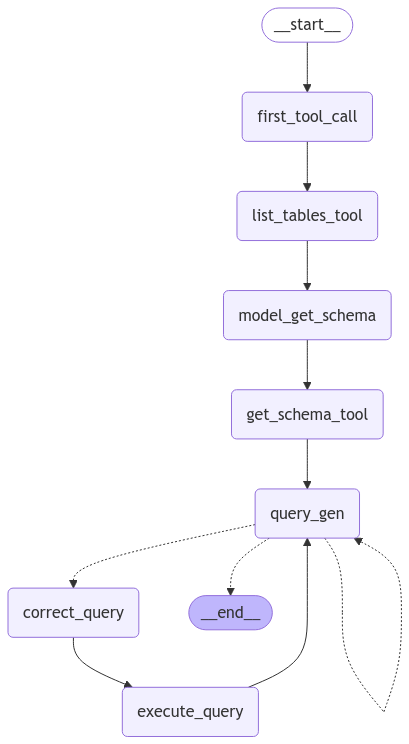

In [67]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [82]:
# Constructing a query as a dictionary, which includes a user question
query={"messages": [{"role": "user", "content": "How many customers are in the customers table? List all customers with their email addresses. Show the phone numbers of customers whose last name is \"Smith.\""}]}

In [78]:
# Invoking the compiled workflow application with the user query
response=app.invoke(query)

In [79]:
# Extracting the final answer from the tool calls in the workflow's response
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

"There are 4 customers in the customers table. The customers with their email addresses are: John Doe - john.doe@example.com, Jane Smith - jane.smith@example.com, Emily Davis - emily.davis@example.com, Michael Brown - michael.brown@example.com. The phone number of the customer whose last name is 'Smith' is: 9876543210"

Basic Questions

About Customers Table: How many customers are in the customers table? List all customers with their email addresses. Show the phone numbers of customers whose last name is "Smith."

About Orders Table: How many orders are in the orders table? What is the total amount of all orders combined? List all orders placed on or after "2023-12-01." Using WHERE Clause: Which customers placed orders greater than $300? Show all customers whose email contains "example.com."

Intermediate Questions

Joins: List all orders with the customer’s first and last name. Find the total amount spent by each customer. Show orders along with customer details where the order amount is greater than $200.

Aggregation: What is the average order amount? How many orders were placed by each customer? What is the highest order amount, and who placed it?

Date Queries: How many orders were placed in December 2023? Show customers who have not placed any orders. Find the most recent order date in the orders table. Advanced Questions Subqueries:

Which customer placed the maximum number of orders? List customers who placed orders totaling more than $500. Find customers who haven't placed any orders yet. Window Functions (if supported):

Rank customers based on the total amount they spent. Show the running total of order amounts by date. Error Handling/Edge Cases:

What happens if a customer ID exists in orders but not in customers? How does the database behave when two customers have the same email address? Testing Agent Capabilities Complex Queries: Show the top 3 customers who spent the most money. List all customers and their total order amount, including those who haven't placed any orders (use LEFT JOIN). Find customers who placed orders only in the last 30 days.